In [1]:
# 사용한 라이브러리
from tensorflow import keras
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import os
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# GPU 사용
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# Data load
path_dir1 = 'dataset/train/rock_train/'
path_dir2 = 'dataset/train/paper/'
path_dir3 = 'dataset/train/scissors_train/'

file_list1 = os.listdir(path_dir1)  # path에 존재하는 파일 목록 가져오기
file_list2 = os.listdir(path_dir2)
file_list3 = os.listdir(path_dir3)

num = 0
X_train = np.float32(np.zeros((1800, 150, 150)))  # 394+413+461
y_train = np.int64(np.zeros((1800)))

for img_name in file_list1:
    img_path = path_dir1 + img_name
    img = mpimg.imread(img_path)/255.0
    x = np.array(img)
    X_train[num, :, :] = x

    y_train[num] = 0  # rock
    num = num + 1

for img_name in file_list2:
    img_path = path_dir2 + img_name
    img = mpimg.imread(img_path)/255.0
    x = np.array(img)
    X_train[num, :, :] = x

    y_train[num] = 1  # paper
    num = num + 1

for img_name in file_list3:
    img_path = path_dir3 + img_name
    img = mpimg.imread(img_path)/255.0
    x = np.array(img)
    X_train[num, :, :] = x

    y_train[num] = 2  # scissors
    num = num + 1

In [3]:
# Data shpae
X_train.shape, y_train.shape

((1800, 150, 150), (1800,))

In [4]:
# Data label
hand_pose_labels = ['rock', 'paper', 'scissors']

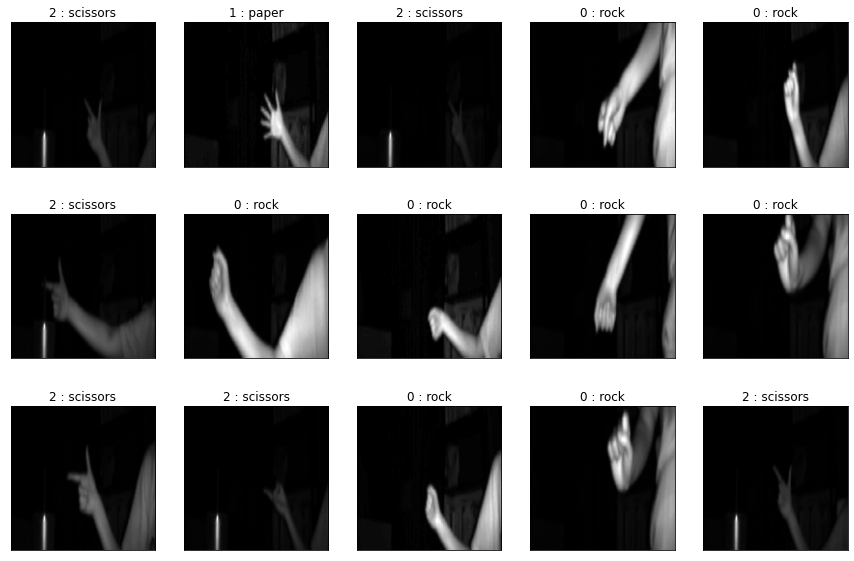

In [5]:
# Data visualization ver.1
figure = plt.figure(figsize=(15, 10))
for index, i in enumerate(np.random.randint(0, X_train.shape[0], 15)):
    ax = figure.add_subplot(3, 5, index + 1, xticks=[], yticks=[])
    ax.imshow(X_train[i], cmap = 'gray')
    ax.set_title(f"{(y_train[i])} : {hand_pose_labels[y_train[i]]}")
plt.show()

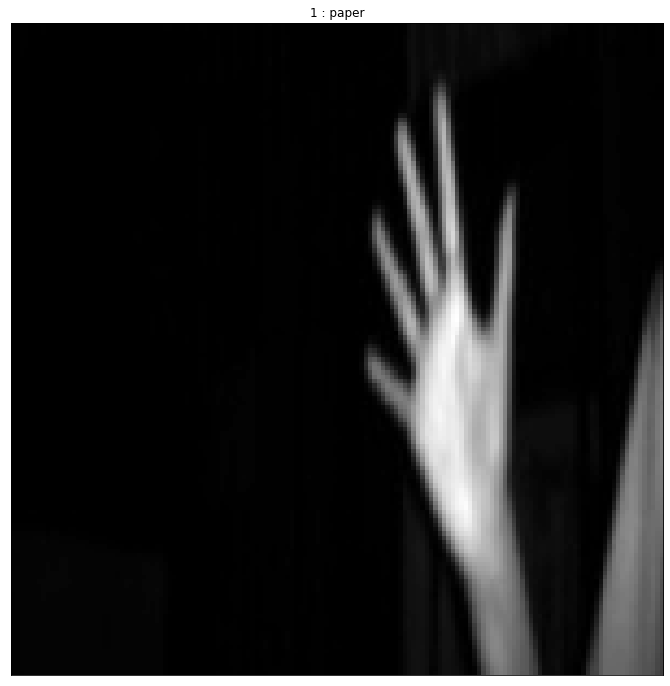

In [6]:
# Data visualization ver.2
plt.figure(figsize=(12,12))
plt.imshow(X_train[800], cmap ='gray')
plt.title(f'{y_train[800]} : {hand_pose_labels[y_train[800]]}')
plt.xticks([])
plt.yticks([])
plt.show()

In [7]:
# Data split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, stratify = y_train, test_size = 0.2, random_state = 87)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((1440, 150, 150), (360, 150, 150), (1440,), (360,))

In [8]:
# Data split -> label & class가 동일한 비율
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 480, 1: 480, 2: 480}

In [9]:
# 0 - 1 Scale check
X_train.min(),  X_train.max()

(0.0, 1.0)

In [10]:
# Data preprocessing(one-hot encoding)
y_train_one_hot = tf.keras.utils.to_categorical(y_train, 3)
y_valid_one_hot = tf.keras.utils.to_categorical(y_valid, 3)

One-Hot encoding: 3이라고 표현된 라벨을 [0,0,1]과 같이 벡터로 바꿔줌
각 class별로 확률을 출력해야하기 때문에 필요한 작업

In [11]:
X_train_cnn = X_train.reshape(X_train.shape[0], 150, 150, 1)
X_valid_cnn = X_valid.reshape(X_valid.shape[0], 150, 150, 1)

# Model 설명
input size: (150, 150, 1)
마지막 layer의 softmax 활성화 함수: 3개의 노드에 대한 확률 출력 -> 가장 높은 값을 예측값으로 사용

In [12]:
cnn_model = tf.keras.Sequential([
    keras.layers.Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu', input_shape = (150, 150, 1)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(filters = 64, kernel_size = 2, padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(filters = 128, kernel_size = 2, padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),

    keras.layers.Conv2D(filters = 128, kernel_size = 2, padding = 'same', activation = 'relu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPooling2D(pool_size = 2),
    keras.layers.Dropout(0.3),

    keras.layers.Flatten(), # Flaatten으로 이미지를 일차원으로 바꿔줌
    keras.layers.Dense(1024, activation = 'relu'),
    keras.layers.Dense(512, activation = 'relu'),
    keras.layers.Dense(256, activation = 'relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(3, activation = 'softmax')
])

In [13]:
cnn_model.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001), metrics=['accuracy'])

In [14]:
checkpointer = ModelCheckpoint(filepath='model.weights.best.cnn.hdf5', verbose=0, save_best_only=True)
earlystopping = EarlyStopping(monitor='val_loss', patience=3)
history = cnn_model.fit(X_train_cnn, y_train_one_hot, batch_size=2, epochs=20, verbose=1, validation_split=0.2, callbacks=[checkpointer, earlystopping])

Epoch 1/20
576/576 [==============================] - 33s 56ms/step - loss: 0.6823 - accuracy: 0.7752 - val_loss: 0.7588 - val_accuracy: 0.6736
Epoch 2/20
576/576 [==============================] - 33s 56ms/step - loss: 0.1776 - accuracy: 0.9479 - val_loss: 0.2566 - val_accuracy: 0.8854
Epoch 3/20
576/576 [==============================] - 33s 57ms/step - loss: 0.0800 - accuracy: 0.9774 - val_loss: 0.1495 - val_accuracy: 0.9757
Epoch 4/20
576/576 [==============================] - 33s 56ms/step - loss: 0.0297 - accuracy: 0.9922 - val_loss: 0.0609 - val_accuracy: 1.0000
Epoch 5/20
576/576 [==============================] - 33s 57ms/step - loss: 0.0115 - accuracy: 0.9948 - val_loss: 0.0391 - val_accuracy: 1.0000
Epoch 6/20
576/576 [==============================] - 33s 57ms/step - loss: 0.0124 - accuracy: 0.9974 - val_loss: 0.0359 - val_accuracy: 1.0000
Epoch 7/20
576/576 [==============================] - 33s 57ms/step - loss: 0.0174 - accuracy: 0.9974 - val_loss: 0.0168 - val_accuracy:

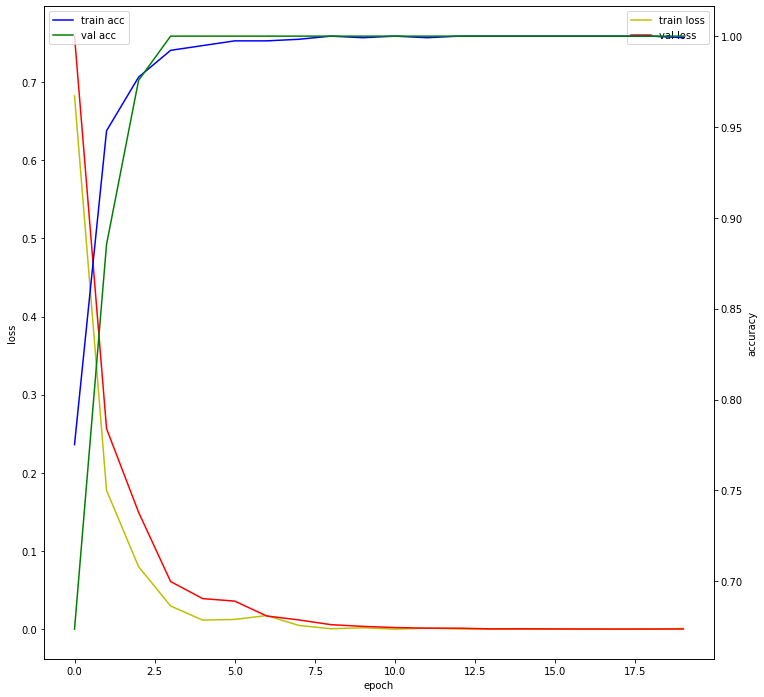

In [15]:
fig, loss_ax = plt.subplots(figsize=(12, 12))
acc_ax = loss_ax.twinx()

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
loss_ax.legend(loc='upper right')

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')
acc_ax.set_ylabel('accuracy')
acc_ax.legend(loc='upper left')

plt.show()

In [16]:
cnn_model.load_weights('model.weights.best.cnn.hdf5')
print('\nAccuracy: {:.4f}'.format(cnn_model.evaluate(X_valid_cnn, y_valid_one_hot)[1]))

12/12 [==============================] - 1s 68ms/step - loss: 1.8849e-04 - accuracy: 1.0000

Accuracy: 1.0000


In [17]:
cnn_model.save('mdel.cnn.h5')

(1, 150, 150, 1)
[[0. 0. 1.]]


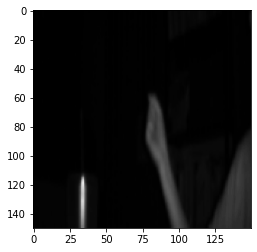

In [38]:
import numpy as np
from keras.preprocessing import image
path = 'dataset/test/rock/img120.png'
img1=image.load_img(path, target_size=(150, 150),color_mode='grayscale')
plt.imshow(img1, cmap='gray')
x1=image.img_to_array(img1)
x1=np.expand_dims(x1, axis=0)
print(x1.shape)
classes1 = cnn_model.predict(x1)
print(classes1)